In [1]:
import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp

In [2]:
## Get all the data

## Get Law Dome

Law_Dome = pd.read_csv('./Conc_fit_data/law2006.txt',index_col=0,skiprows=183,nrows=2188-184,delim_whitespace=True,usecols=[0,3,5,8],names=['Year','CH4','CO2','N2O'])

# Get NOAA atmospheric observations

obsv_concs = pd.read_csv('./Conc_fit_data/NOAA_Conc_data.csv',skiprows=4,header=None,index_col=0).dropna().iloc[:,:3].values
obsv_concs = pd.DataFrame(data=obsv_concs,index = np.arange(1979,2018),columns=['CO2','CH4','N2O'])

# Get CMIP6 concs:

CMIP6_concs = pd.read_csv('./CMIP_input_ems/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)

In [3]:
# Get and harmonize emissions

N2O_ems_1890_1990 = pd.read_csv('./Conc_fit_data/edgar_hyde1.4-glob_n2o.csv',index_col=0)
N2O_ems_1970_2012 = pd.read_csv('./Conc_fit_data/v432_N2O_1970_2012.csv',index_col=0)

CH4_ems_1850_2014 = pd.read_csv('./Conc_fit_data/CEDS_CH4_global_emissions_1850_2014.csv',index_col=0,names=['Year','CH4'])
CO2_ems_1750_2014 = pd.read_csv('./Conc_fit_data/CEDS_CO2_global_emissions_1750_2014.csv',index_col=0,names=['Year','CO2'])*(12/44)

RCP85_E = pd.read_csv('./RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)
RCP_ems = pd.DataFrame(data = np.array([RCP85_E[['OtherCO2','FossilCO2']].sum(axis=1).values,RCP85_E['CH4'].values,RCP85_E['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = RCP85_E.index)

## Now we need to harmonise the datasets to get a full 1765 - 2015 run

N2O_ems_1890_1970_vals = (N2O_ems_1890_1990.loc[range(1890,1970)] * N2O_ems_1970_2012.loc[1970] / N2O_ems_1890_1990.loc[1970]).values.flatten()
N2O_ems_1765_1890_vals = (RCP_ems.N2O.loc[range(1765,1890)] * N2O_ems_1890_1970_vals[0] / RCP_ems.N2O.loc[1890]).values
N2O_ems_1970_2012_vals = N2O_ems_1970_2012.values.flatten()

N2O_ems_1765_2012 = pd.DataFrame(np.concatenate((N2O_ems_1765_1890_vals,N2O_ems_1890_1970_vals,N2O_ems_1970_2012_vals)),columns=['N2O'],index = np.arange(1765,2013))
N2O_ems_1765_2012 = N2O_ems_1765_2012.interpolate(method='linear',axis=0)


CH4_ems_1850_2014_vals = CH4_ems_1850_2014.drop_duplicates().values.flatten()
CH4_ems_1765_1850_vals = (RCP_ems.CH4.loc[range(1765,1850)] * CH4_ems_1850_2014_vals[0] / RCP_ems.CH4.loc[1850]).values.flatten()

CH4_ems_1765_2014 = pd.DataFrame(np.concatenate((CH4_ems_1765_1850_vals,CH4_ems_1850_2014_vals)),columns=['CH4'],index = np.arange(1765,2015))

CO2_ems_1765_2014 = CO2_ems_1750_2014.loc[1765:] ## Not including OtherCO2 for now? CEDS seems to be fossil co2

# Alternative CO2 emissions
GCP = pd.read_csv('./Conc_fit_data/Global_Carbon_Budget_2018v1.0.csv',index_col=0)
GCP_CO2 = GCP.fillna(0).sum(axis=1)
GCP_CO2.loc[1765:1849] += (RCP85_E.OtherCO2.loc[:1849] * GCP.loc[1850].iloc[1] / RCP85_E.OtherCO2.loc[1850]).values

#emissions = (CO2_ems_1765_2014+pd.DataFrame(data=RCP85_E.OtherCO2.loc[:2014].values,columns=['CO2'],index=CO2_ems_1765_2014.index)).copy()
emissions = pd.DataFrame(data= GCP_CO2.loc[1765:2014],columns=['CO2'],index=GCP_CO2.loc[1765:2014].index)
emissions['CH4'] = CH4_ems_1765_2014
emissions['N2O'] = N2O_ems_1765_2012
emissions['N2O'].loc[2013] = 2*emissions['N2O'].loc[2012] - emissions['N2O'].loc[2011]
emissions['N2O'].loc[2014] = 2*emissions['N2O'].loc[2013] - emissions['N2O'].loc[2012]
emissions['N2O'] = emissions['N2O']*6.6 / emissions.N2O.loc[2010]

/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [4]:
## Get a temp response
forcings = pd.read_csv('./Conc_fit_data/Annualforcings_Mar2014_GHGrevised.txt',skiprows=3,sep='\t',index_col=0)
empty_ems = pd.DataFrame(index=forcings.index,columns=['CO2','CH4','N2O']).fillna(0.)
T_ant = UnFaIR(emissions_in=empty_ems,F_ext=forcings.Anthrototal.values)['T']
T_nat = UnFaIR(emissions_in=empty_ems,F_ext=(forcings.Total.values - forcings.Anthrototal.values))['T']

T_response = (T_ant*0.912621338044 + T_nat*0.395722694204).loc[range(1765,2015)]

In [272]:
params = default_gas_params()

#CO2_fit = sp.optimize.minimize(fit_gas_cycles,np.array([0,0,0]),args=(emissions,obsv_concs,T_response,'CO2'),method='Powell')
#CH4_fit = sp.optimize.minimize(fit_gas_cycles,np.array([0,0,0,9]),args=(emissions,obsv_concs,T_response+0.1,'CH4',params),method='Powell')
#N2O_fit = sp.optimize.minimize(fit_gas_cycles,np.array([0,0,0]),args=(emissions,obsv_concs,T_response,'N2O'),method='Powell')

def exact_fit(x,s,observed_concs):
    
    fit_params = params.copy()
    
    if s == 'CO2':
        fit_params.loc['r0':'rT'][s] = np.array([x[0],x[1],x[2]])
    if s == 'CH4':
        fit_params.loc['r0':'rA'][s] = np.array([x[0],0,x[1],x[2]])
    if s == 'N2O':
        fit_params.loc['r0':'rA'][s] = np.array([x[0],0,0,x[1]])
        
    result = fit_gas_cycles(emissions,T_response,fit_params)
    
    # Let's do a combo grad
    
    grad_scaling = {'CO2':0,'CH4':0,'N2O':0}
    
    return np.sum(observed_concs.index.values**2 * ((result[s].loc[observed_concs.index] - observed_concs[s]).dropna().values)**2) + np.sum(((result[s].loc[observed_concs.index].diff() - observed_concs[s].diff()).dropna().values)**2)*grad_scaling[s]

bnds = ((20,50),(0.0,0.05),(0,8))
CO2_grad_fit = sp.optimize.minimize(exact_fit,[32,0.02,4],args=('CO2',CMIP6_concs[['CO2','CH4','N2O']].loc[1960:]),method='L-BFGS-B',bounds=bnds)
bnds = ((7,10),(-0.5,0),(0,1e-03))
CH4_grad_fit = sp.optimize.minimize(exact_fit,[9,-3.6e-01,3e-04],args=('CH4',CMIP6_concs[['CO2','CH4','N2O']].loc[1960:]),method='L-BFGS-B',bounds=bnds)
bnds = ((40,80),(-2e-03,0))
N2O_grad_fit = sp.optimize.minimize(exact_fit,[70,-9e-04],args=('N2O',CMIP6_concs[['CO2','CH4','N2O']].loc[1960:]),method='L-BFGS-B',bounds=bnds)

/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [273]:
print(CO2_grad_fit)
print(CH4_grad_fit)
print(N2O_grad_fit)

      fun: 349829959.1758697
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.01674795e+06, -1.38126761e+09,  3.80530357e+06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 10
   status: 0
  success: True
        x: array([23.72605272,  0.05      ,  1.24219582])
      fun: 262489448205.0265
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.59864764e+11,  1.35015839e+11,  2.22778320e+05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 148
      nit: 33
   status: 0
  success: True
        x: array([ 1.00000000e+01, -5.00000000e-01,  1.73397619e-04])
      fun: 1069489011.5804366
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.02655792e+02,  9.69056344e+09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 5
   status: 0
  success: True
        x: array([ 6.92864776e+01, -2.00000000e-03])


In [5]:
## Get an "other" forcing dataset:
RCP85_forc = pd.read_csv('./Conc_fit_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

otherforc = RCP85_forc.TOTAL_INCLVOLCANIC_RF.loc[:2014].values - RCP85_forc.CO2CH4N2O_RF.loc[:2014].values

                      CO2         CH4         N2O
a1               0.217300    1.000000    1.000000
a2               0.224000    0.000000    0.000000
a3               0.282400    0.000000    0.000000
a4               0.276300    0.000000    0.000000
tau1       1000000.000000    9.150000  116.000000
tau2           394.400000    1.000000    1.000000
tau3            36.540000    1.000000    1.000000
tau4             4.304000    1.000000    1.000000
r0              32.400000    8.620000   67.231092
rC               0.019000    0.000000    0.000000
rT               4.165000   -0.600000    0.000000
rA               0.000000    0.000380   -0.000906
PI_conc        278.000000  700.000000  273.000000
emis2conc        0.468952    0.351714    0.200980


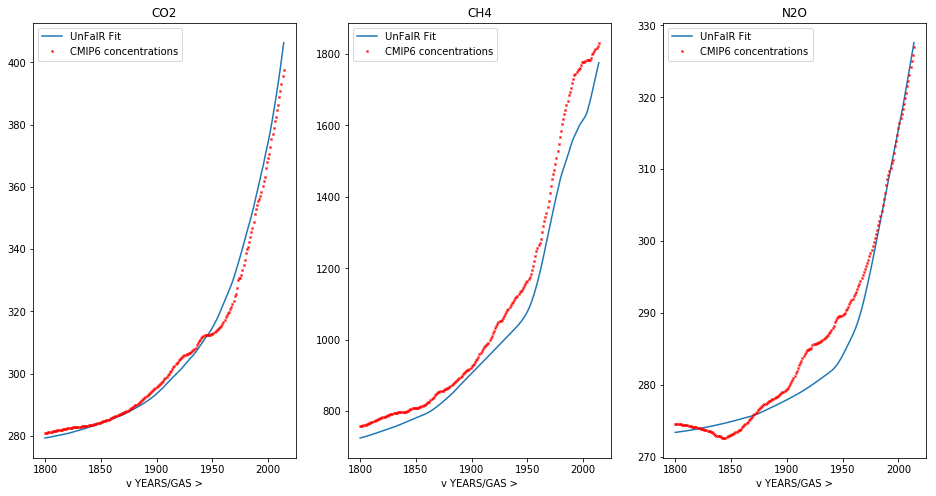

In [48]:
# NB CO2_fit contains the previously used parameter set

# Try with Prather CH4 values
#params.loc['r0'] = np.array([CO2_grad_fit['x'][0],CH4_grad_fit['x'][0],N2O_grad_fit['x'][0]]) # CH4 Prather : 8.53773764 (8.65) # N2O 67.23109226573325
#params.loc['rC'] = np.array([CO2_grad_fit['x'][1],0,0])
#params.loc['rT'] = np.array([CO2_grad_fit['x'][2],CH4_grad_fit['x'][1],0]) # CH4 Prather : -3.60100511e-01 (-4.3e-01)
#params.loc['rA'] = np.array([0,CH4_grad_fit['x'][2],N2O_grad_fit['x'][1]]) # CH4 Prather : 3.09667588e-04 (3.17e-04) # N2O -0.00090625

params = default_gas_params()

params.loc['r0':'rT'].CO2 = np.array([32.4,0.019,4.165])#CO2_grad_fit['x']
#params.loc[['r0','rT','rA'],'CH4'] = CH4_grad_fit['x']
#params.loc[['r0','rA'],'N2O'] = N2O_grad_fit['x']

params.loc[['r0','rT','rA'],'CH4'] = np.array([8.62,-6e-01,3.8e-04])

print(params)

result = UnFaIR(emissions_in=emissions,F_ext=otherforc,gas_params=params)

fig,ax=plt.subplots(1,3,figsize=(16,8))
for i,s in enumerate(['CO2','CH4','N2O']):
    result['C'][s].loc[1800:].plot(ax=ax[i],label='UnFaIR Fit')
    #obsv_concs[s].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='r',label='NOAA observation (atmos)')
    #Law_Dome[s].loc[1800:].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='k', label='Law Dome measurement')
    CMIP6_concs[s].loc[1800:].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='r',label='CMIP6 concentrations')
    ax[i].set_title(s)
    ax[i].legend()

In [49]:
## Running RCP8.5 through...
RCP85_E = pd.read_csv('./RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)
RCP85_ems = pd.DataFrame(data = np.array([RCP85_E[['OtherCO2','FossilCO2']].sum(axis=1).values,RCP85_E['CH4'].values,RCP85_E['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = RCP85_E.index)

future_emissions = emissions.append(RCP85_ems.loc[2015:] - RCP85_ems.loc[2014] + emissions.loc[2014])

#run_params.loc['r0':'rT'].CO2 = CO2_grad_fit['x']
#run_params.loc[['r0','rT','rA'],'CH4'] = CH4_grad_fit['x']
#run_params.loc[['r0','rA'],'N2O'] = N2O_grad_fit['x']


print(params)

RCP85_results = UnFaIR(emissions_in=future_emissions,F_ext=RCP85_forc.TOTAL_INCLVOLCANIC_RF.values - RCP85_forc.CO2CH4N2O_RF.values,gas_params=params)

                      CO2         CH4         N2O
a1               0.217300    1.000000    1.000000
a2               0.224000    0.000000    0.000000
a3               0.282400    0.000000    0.000000
a4               0.276300    0.000000    0.000000
tau1       1000000.000000    9.150000  116.000000
tau2           394.400000    1.000000    1.000000
tau3            36.540000    1.000000    1.000000
tau4             4.304000    1.000000    1.000000
r0              32.400000    8.620000   67.231092
rC               0.019000    0.000000    0.000000
rT               4.165000   -0.600000    0.000000
rA               0.000000    0.000380   -0.000906
PI_conc        278.000000  700.000000  273.000000
emis2conc        0.468952    0.351714    0.200980


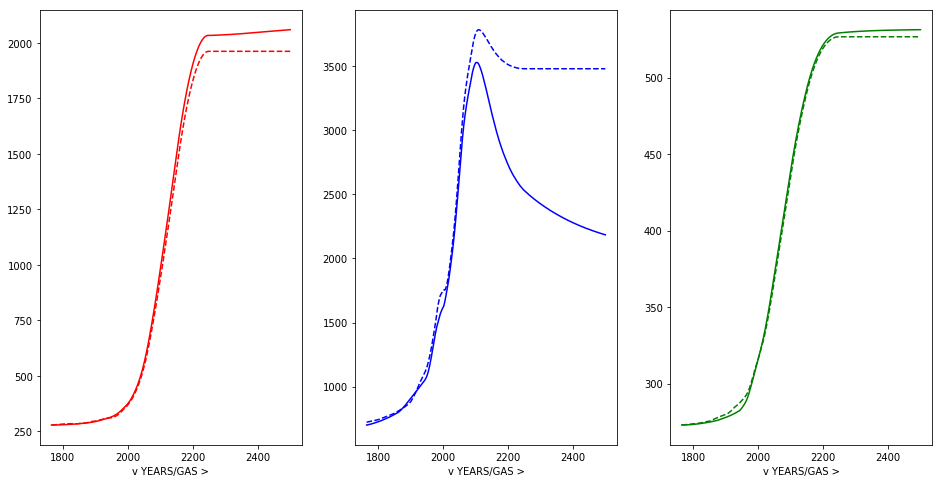

In [50]:
## Compare concs to RCP data:
RCP85_C = pd.read_csv('./RCP_data/RCP85_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0)

colors={'CO2':'r','CH4':'b','N2O':'g'}

fig,ax=plt.subplots(1,3,figsize=(16,8))
for i,s in enumerate(['CO2','CH4','N2O']):
    RCP85_results['C'][s].plot(ax=ax[i],color=colors[s])
    RCP85_C[s].plot(ax=ax[i],color=colors[s],linestyle='--')


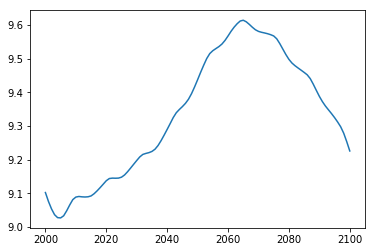

In [51]:
(RCP85_results['alpha']['CH4']*run_params.loc['tau1']['CH4']).loc[2000:2100].plot()

In [58]:
UnFaIR(emissions_in = pd.DataFrame(data=np.array([[10,10,10]]),columns=['CO2','CH4','N2O']))

{'C':           CO2         CH4         N2O
 0  282.195207  703.315137  275.001233,
 'RF':         CO2       CH4       N2O  F_ext     Total
 0  0.080816  0.002253  0.007254    0.0  0.090323,
 'T':      Total
 0  0.00814,
 'alpha':         CO2       CH4       N2O
 0  0.271626  0.914637  1.008849,
 'E':    CO2  CH4  N2O
 0   10   10   10,
 'gas_params':                       CO2         CH4         N2O
 a1               0.217300    1.000000    1.000000
 a2               0.224000    0.000000    0.000000
 a3               0.282400    0.000000    0.000000
 a4               0.276300    0.000000    0.000000
 tau1       1000000.000000    9.150000  116.000000
 tau2           394.400000    1.000000    1.000000
 tau3            36.540000    1.000000    1.000000
 tau4             4.304000    1.000000    1.000000
 r0              37.493303    8.540000   67.231092
 rC               0.019090    0.000000    0.000000
 rT               3.616153   -0.360000    0.000000
 rA               0.000000    0.000